In [ ]:
# Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from functools import partial
import copy
import matplotlib.pyplot as plt
from google.colab import drive
import os
import pickle

In [ ]:
#Link Google drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/Colab Notebooks/AAAI Experiment 2 Results'
os.makedirs(save_dir, exist_ok=True)

Mounted at /content/drive


Define functions and classes:

In [ ]:
# Define the gold standard neural network class inheriting from nn.Module
class gs_neural_net(nn.Module):
    def __init__(self, hidden_layers_vector):
        super(gs_neural_net, self).__init__()
        self.input_size = 16
        self.output_size = 8
        self.num_actions = 8
        self.hidden_layers_vector = hidden_layers_vector

        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(self.input_size, self.hidden_layers_vector[0]))
        for i in range(1, len(self.hidden_layers_vector)):
            self.hidden_layers.append(nn.Linear(self.hidden_layers_vector[i - 1] + self.num_actions, self.hidden_layers_vector[i]))
        self.output_layer = nn.Linear(self.hidden_layers_vector[-1] + self.num_actions, self.output_size)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.zeros_(self.hidden_layers[0].bias)
        nn.init.kaiming_normal_(self.hidden_layers[0].weight, mode='fan_in', nonlinearity='relu')

        for i in range(1, len(self.hidden_layers)):
            nn.init.kaiming_normal_(self.hidden_layers[i].weight, mode='fan_in', nonlinearity='relu')
            nn.init.zeros_(self.hidden_layers[i].bias)

        nn.init.zeros_(self.output_layer.bias)
        nn.init.kaiming_normal_(self.output_layer.weight, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        actions = x[:, 8:]
        h = F.relu(self.hidden_layers[0](x))
        for layer in self.hidden_layers[1:]:
            # Add a skip-layer connection for the actions so that they meaningfully affect the outcome
            h = F.relu(layer(torch.cat([h, actions], dim=1)))
        # Increase the final skip-layer connection to further increase the impact of actions
        output = self.output_layer(torch.cat([h, actions * 2 * h.size(1) ** 0.5], dim=1))
        return F.softmax(output, dim=1)

In [ ]:
# Define the data generation process for the eight environmental variables
def generate_environment(num_samples=(2 ** 16)):
    #Multiplying by sqrt(12) gives U(0,1) the same variance as N(0,1), but keeps it over a bounded range
    environments = (12 ** 0.5) * torch.rand(num_samples, 8)
    return environments

In [ ]:
# Define a function to add each of eight possible actions to each environment, creating inputs of length sixteen
def expand_tensor(input_tensor):
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)
    expanded_tensor = torch.zeros((input_tensor.shape[0] * 8, input_tensor.shape[1] + 8))
    for i in range(input_tensor.shape[0]):
        vector = input_tensor[i]
        for j in range(8):
            appended_vector = torch.zeros(8)
            appended_vector[j] = 1
            expanded_tensor[8 * i + j, :] = torch.cat([vector, appended_vector])
    return expanded_tensor

In [ ]:
# Define a variant on DataLoader that will sample data in blocks of eight
# This ensures all eight actions for the same environment appear adjacent in the same block
class BlockLoader:
    def __init__(self, inputs, model=None, block_size=8, batch_size=64):
        self.inputs = inputs
        self.targets = None
        self.block_size = block_size
        self.batch_size = batch_size
        self.num_samples = self.inputs.shape[0]
        self.num_blocks = self.num_samples // self.block_size

        if model is not None:
          self.update_targets(model)

    def update_targets(self, model):
        with torch.no_grad():
            self.targets = model(self.inputs)

    def __iter__(self):
        block_indices = torch.randperm(self.num_blocks)

        for i in range(0, self.num_blocks, self.batch_size):
            batch_block_indices = block_indices[i:i + self.batch_size]
            batch_inputs = []

            for id in batch_block_indices:
                start_id = id * self.block_size
                end_id = start_id + self.block_size
                batch_inputs.append(self.inputs[start_id:end_id])

            if self.targets is not None:
                batch_targets = []
                for id in batch_block_indices:
                    start_id = id * self.block_size
                    end_id = start_id + self.block_size
                    batch_targets.append(self.targets[start_id:end_id])
                yield torch.cat(batch_inputs, dim=0), torch.cat(batch_targets, dim=0)
            else:
                yield torch.cat(batch_inputs, dim=0)

    def __len__(self):
        return self.num_samples // (self.batch_size * self.block_size)

In [ ]:
# Define the neural network to be trained
class neural_network(nn.Module):
    def __init__(self, num_hidden_layers=4, hidden_size=64, hidden_dropout_rate=0.5, input_dropout_rate=0.25):
        super(neural_network, self).__init__()
        self.input_size = 16
        self.output_size = 8
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers

        self.hidden_dropout_rate = hidden_dropout_rate
        self.input_dropout_rate = input_dropout_rate

        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(self.input_size, self.hidden_size))
        for _ in range(1, self.num_hidden_layers):
            self.hidden_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        self.output_layer = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        batch_size = x.size(0)

        if self.training and self.input_dropout_rate > 0:
            # Apply input dropout to the first 8 values, representing the environment, but not the actions which are all being conditionally predicted
            # The same dropout mask is applied to all eight actions with the same environment
            input_mask = F.dropout(torch.ones(batch_size // 8, 8), p=self.input_dropout_rate, training=True)
            input_mask = input_mask.repeat_interleave(8, dim=0)
            input_mask = torch.cat([input_mask, torch.ones(batch_size, 8)], dim=1)
            x = torch.mul(x, input_mask)

        for layer in self.hidden_layers:
            x = F.relu(layer(x))

            if self.training and self.hidden_dropout_rate > 0:
                mask = F.dropout(torch.ones(batch_size // 8, layer.out_features), p=self.hidden_dropout_rate, training=True)
                mask = mask.repeat_interleave(8, dim=0)
                x = torch.mul(x, mask)

        x = self.output_layer(x)
        return F.softmax(x, dim=1)

In [ ]:
# Training function
def train_model_performative(model, utilities, optimizer, criterion, data_loader, epochs, report_interval=None, record_loss = False):
    if report_interval is not None:
      total_loss = 0
      total_np_loss = 0
      total_prob_fav = 0
      total_utility = 0
      batch_count = 0

    if record_loss:
      batch_losses = []
      batch_np_losses = []
      batch_prob_favs = []
      batch_utilities = []

    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()

            #Two forward passes for comparison to zero-sum model
            outputs1 = model(inputs)
            outputs2 = model(inputs)

            # Decrease the temperature every epoch to create greater incentivs for performativity
            loss1, np_loss1, prob_fav1, utility1 = criterion(outputs1, targets, utilities, one_over_temperature=(1 + epoch))
            loss2, np_loss2, prob_fav2, utility2 = criterion(outputs2, targets, utilities, one_over_temperature=(1 + epoch))
            loss = (loss1 + loss2)/2
            np_loss = (np_loss1 + np_loss2)/2
            prob_fav = (prob_fav1 + prob_fav2)/2
            utility = (utility1 + utility2)/2

            loss.backward()
            optimizer.step()

            if record_loss:
              batch_losses.append(loss.item())
              batch_np_losses.append(np_loss.item())
              batch_prob_favs.append(prob_fav.item())
              batch_utilities.append(utility.item())

            if report_interval is not None:
              total_loss += loss.item()
              total_np_loss += np_loss.item()
              total_prob_fav += prob_fav.item()
              total_utility += utility.item()
              batch_count += 1
              if batch_count % report_interval == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_count}, Average Loss: {total_loss/ report_interval:.5f}, Average NP Loss: {total_np_loss/ report_interval:.5f}, Average Prob Fav: {total_prob_fav/ report_interval:.5f}, Average Utility: {total_utility/ report_interval:.5f} ')
                total_loss = 0.0
                total_np_loss = 0.0
                total_prob_fav = 0.0
                total_utility = 0.0

    if record_loss:
      batch_losses_tensor = torch.tensor(batch_losses)
      batch_np_losses_tensor = torch.tensor(batch_np_losses)
      batch_prob_favs_tensor = torch.tensor(batch_prob_favs)
      batch_utilities_tensor = torch.tensor(batch_utilities)

      return batch_losses_tensor, batch_np_losses_tensor, batch_prob_favs_tensor, batch_utilities_tensor

In [ ]:
# Loss function (Kullback-Leibler Divergence, weighted by probability of choosing that action, ignoring term that depends only on y_true)
def criterion_performative(y_pred, y_true, utilities, one_over_temperature):
    # The principal's probability of choosing each action
    action_values = y_pred @ utilities * one_over_temperature
    reshaped_av = action_values.reshape(action_values.size(0)//8, 8)
    action_probs = F.softmax(reshaped_av, dim=1)
    action_probs = action_probs.reshape(action_values.size(0))
    # The agent's score conditional on each action
    log_probs = torch.log(y_pred + 1e-10)
    unweighted_losses = -torch.sum(y_true * log_probs, dim=1)
    # Weighting
    weighted_losses = unweighted_losses * action_probs

    # The principal's preferred action under the true distributions
    true_action_values = y_true @ utilities
    reshaped_tav = true_action_values.reshape(true_action_values.size(0)//8, 8)
    max_indices = torch.argmax(reshaped_tav, dim=1)
    favorites = torch.zeros_like(reshaped_tav)
    favorites[torch.arange(reshaped_tav.shape[0]), max_indices] = 1
    favorites = favorites.reshape(true_action_values.size(0))
    prob_fav = favorites * action_probs
    utility = true_action_values * action_probs

    return torch.mean(weighted_losses * 8), torch.mean(unweighted_losses), torch.mean(prob_fav * 8), torch.mean(utility * 8)


In [ ]:
# Training function
def train_model_zero_sum(model, utilities, optimizer, criterion, data_loader, epochs, report_interval=None, record_loss = False):
    if report_interval is not None:
      total_loss = 0
      total_w_loss = 0
      total_np_loss = 0
      total_prob_fav = 0
      total_utility = 0
      batch_count = 0

    if record_loss:
      batch_w_losses = []
      batch_np_losses = []
      batch_prob_favs = []
      batch_utilities = []

    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()

            outputs1 = model(inputs)
            outputs2 = model(inputs)

            loss1, w_loss1, np_loss1, prob_fav1, utility1 = criterion(outputs1, outputs2.detach(), targets, utilities)
            loss2, w_loss2, np_loss2, prob_fav2, utility2 = criterion(outputs2, outputs1.detach(), targets, utilities)
            loss = (loss1 + loss2)/2
            w_loss = (w_loss1 + w_loss2)/2
            np_loss = (np_loss1 + np_loss2)/2
            prob_fav = (prob_fav1 + prob_fav2)/2
            utility = (utility1 + utility2)/2

            loss.backward()
            optimizer.step()

            if record_loss:
              batch_w_losses.append(w_loss.item())
              batch_np_losses.append(np_loss.item())
              batch_prob_favs.append(prob_fav.item())
              batch_utilities.append(utility.item())

            if report_interval is not None:
              total_loss += loss.item()
              total_w_loss += w_loss.item()
              total_np_loss += np_loss.item()
              total_prob_fav += prob_fav.item()
              total_utility += utility.item()
              batch_count += 1
              if batch_count % report_interval == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_count}, Average Loss: {total_loss/ report_interval:.5f}, Average W Loss: {total_w_loss/ report_interval:.5f}, Average NP Loss: {total_np_loss/ report_interval:.5f}, Average Prob Fav: {total_prob_fav/ report_interval:.5f}, Average Utility: {total_utility/ report_interval:.5f} ')
                total_loss = 0.0
                total_w_loss = 0.0
                total_np_loss = 0.0
                total_prob_fav = 0.0
                total_utility = 0.0

    if record_loss:
      batch_w_losses_tensor = torch.tensor(batch_w_losses)
      batch_np_losses_tensor = torch.tensor(batch_np_losses)
      batch_prob_favs_tensor = torch.tensor(batch_prob_favs)
      batch_utilities_tensor = torch.tensor(batch_utilities)

      return batch_w_losses_tensor, batch_np_losses_tensor, batch_prob_favs_tensor, batch_utilities_tensor

In [ ]:
# Training function
def train_model_zero_sum_exact(model, utilities, optimizer, criterion, data_loader, epochs, report_interval=None, record_loss = False):
    if report_interval is not None:
      total_loss = 0
      total_w_loss = 0
      total_np_loss = 0
      total_prob_fav = 0
      total_utility = 0
      batch_count = 0

    if record_loss:
      batch_w_losses = []
      batch_np_losses = []
      batch_prob_favs = []
      batch_utilities = []

    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()

            outputs1 = model(inputs)
            outputs2 = model(inputs)

            loss1, w_loss1, np_loss1, prob_fav1, utility1 = criterion(outputs1, outputs1.detach(), targets, utilities)
            loss2, w_loss2, np_loss2, prob_fav2, utility2 = criterion(outputs2, outputs2.detach(), targets, utilities)
            loss = (loss1 + loss2)/2
            w_loss = (w_loss1 + w_loss2)/2
            np_loss = (np_loss1 + np_loss2)/2
            prob_fav = (prob_fav1 + prob_fav2)/2
            utility = (utility1 + utility2)/2

            loss.backward()
            optimizer.step()

            if record_loss:
              batch_w_losses.append(w_loss.item())
              batch_np_losses.append(np_loss.item())
              batch_prob_favs.append(prob_fav.item())
              batch_utilities.append(utility.item())

            if report_interval is not None:
              total_loss += loss.item()
              total_w_loss += w_loss.item()
              total_np_loss += np_loss.item()
              total_prob_fav += prob_fav.item()
              total_utility += utility.item()
              batch_count += 1
              if batch_count % report_interval == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_count}, Average Loss: {total_loss/ report_interval:.5f}, Average W Loss: {total_w_loss/ report_interval:.5f}, Average NP Loss: {total_np_loss/ report_interval:.5f}, Average Prob Fav: {total_prob_fav/ report_interval:.5f}, Average Utility: {total_utility/ report_interval:.5f} ')
                total_loss = 0.0
                total_w_loss = 0.0
                total_np_loss = 0.0
                total_prob_fav = 0.0
                total_utility = 0.0

    if record_loss:
      batch_w_losses_tensor = torch.tensor(batch_w_losses)
      batch_np_losses_tensor = torch.tensor(batch_np_losses)
      batch_prob_favs_tensor = torch.tensor(batch_prob_favs)
      batch_utilities_tensor = torch.tensor(batch_utilities)

      return batch_w_losses_tensor, batch_np_losses_tensor, batch_prob_favs_tensor, batch_utilities_tensor

In [ ]:
# Loss function (Kullback-Leibler Divergence, weighted by probability of choosing that action, ignore term that depends only on y_true)
def criterion_zero_sum(y_pred1, y_pred2, y_true, utilities):
    # The principal's probability of choosing each action
    action_values_1 = y_pred1 @ utilities
    action_values_2 = y_pred2 @ utilities
    # Multiply by four so it has the same incentive performativity as the perfomative model ends on
    action_values_optimistic = torch.max(action_values_1, action_values_2) * 4
    reshaped_av = action_values_optimistic.reshape(action_values_optimistic.size(0)//8, 8)
    action_probs = F.softmax(reshaped_av, dim=1)
    action_probs = action_probs.reshape(action_values_optimistic.size(0))
    # The agent's score conditional on each action
    log_probs1 = torch.log(y_pred1 + 1e-10)
    log_probs2 = torch.log(y_pred2 + 1e-10)
    unweighted_losses1 = -torch.sum(y_true * log_probs1, dim=1)
    unweighted_losses2 = -torch.sum(y_true * log_probs2, dim=1)
    # Weighting
    weighted_losses1 = unweighted_losses1 * action_probs
    weighted_losses2 = unweighted_losses2 * action_probs
    zero_sum_losses = weighted_losses1 - weighted_losses2

    # The principal's preferred action under the true distributions
    true_action_values = y_true @ utilities
    reshaped_tav = true_action_values.reshape(true_action_values.size(0)//8, 8)
    max_indices = torch.argmax(reshaped_tav, dim=1)
    favorites = torch.zeros_like(reshaped_tav)
    favorites[torch.arange(reshaped_tav.shape[0]), max_indices] = 1
    favorites = favorites.reshape(true_action_values.size(0))
    prob_fav = favorites * action_probs
    utility = true_action_values * action_probs

    return torch.mean(zero_sum_losses * 8), torch.mean(weighted_losses1 * 8), torch.mean(unweighted_losses1), torch.mean(prob_fav * 8), torch.mean(utility * 8)


In [ ]:
# Training function
def train_model_stopgrad(model, utilities, optimizer, criterion, data_loader, epochs, report_interval=None, record_loss = False):
    if report_interval is not None:
      total_loss = 0
      total_np_loss = 0
      total_prob_fav = 0
      total_utility = 0
      batch_count = 0

    if record_loss:
      batch_losses = []
      batch_np_losses = []
      batch_prob_favs = []
      batch_utilities = []

    model.train()
    for epoch in range(epochs):
        for inputs, targets in data_loader:
            optimizer.zero_grad()

            outputs = model(inputs)

            loss, np_loss, prob_fav, utility = criterion(outputs, outputs.detach(), targets, utilities)

            outputs1 = model(inputs)
            outputs2 = model(inputs)

            loss1, np_loss1, prob_fav1, utility1 = criterion(outputs1, outputs1.detach(), targets, utilities)
            loss2, np_loss2, prob_fav2, utility2 = criterion(outputs2, outputs2.detach(), targets, utilities)
            loss = (loss1 + loss2)/2
            np_loss = (np_loss1 + np_loss2)/2
            prob_fav = (prob_fav1 + prob_fav2)/2
            utility = (utility1 + utility2)/2

            loss.backward()
            optimizer.step()

            if record_loss:
              batch_losses.append(loss.item())
              batch_np_losses.append(np_loss.item())
              batch_prob_favs.append(prob_fav.item())
              batch_utilities.append(utility.item())

            if report_interval is not None:
              total_loss += loss.item()
              total_np_loss += np_loss.item()
              total_prob_fav += prob_fav.item()
              total_utility += utility.item()
              batch_count += 1
              if batch_count % report_interval == 0:
                print(f'Epoch {epoch + 1}, Batch {batch_count}, Average Loss: {total_p_loss/ report_interval:.5f},  Average NP Loss: {total_np_loss/ report_interval:.5f}, Average Prob Fav: {total_prob_fav/ report_interval:.5f}, Average Utility: {total_utility/ report_interval:.5f} ')
                total_loss = 0.0
                total_np_loss = 0.0
                total_prob_fav = 0.0
                total_utility = 0.0

    if record_loss:
      batch_losses_tensor = torch.tensor(batch_losses)
      batch_np_losses_tensor = torch.tensor(batch_np_losses)
      batch_prob_favs_tensor = torch.tensor(batch_prob_favs)
      batch_utilities_tensor = torch.tensor(batch_utilities)

      return batch_losses_tensor, batch_np_losses_tensor, batch_prob_favs_tensor, batch_utilities_tensor

In [ ]:
# Loss function (Kullback-Leibler Divergence, weighted by probability of choosing that action, ignore term that depends only on y_true)
def criterion_stopgrad(y_pred1, y_pred2, y_true, utilities):
    # The principal's probability of choosing each action
    # Multiply by four so it has the same incentive performativity as the perfomative model ends on
    action_values = y_pred2 @ utilities * 4
    reshaped_av = action_values.reshape(action_values.size(0)//8, 8)
    action_probs = F.softmax(reshaped_av, dim=1)
    action_probs = action_probs.reshape(action_values.size(0))
    # The agent's score conditional on each action
    log_probs = torch.log(y_pred1 + 1e-10)
    unweighted_losses = -torch.sum(y_true * log_probs, dim=1)
    # Weighting
    weighted_losses = unweighted_losses * action_probs

    # The principal's preferred action under the true distributions
    true_action_values = y_true @ utilities
    reshaped_tav = true_action_values.reshape(true_action_values.size(0)//8, 8)
    max_indices = torch.argmax(reshaped_tav, dim=1)
    favorites = torch.zeros_like(reshaped_tav)
    favorites[torch.arange(reshaped_tav.shape[0]), max_indices] = 1
    favorites = favorites.reshape(true_action_values.size(0))
    prob_fav = favorites * action_probs
    utility = true_action_values * action_probs

    return  torch.mean(weighted_losses * 8), torch.mean(unweighted_losses), torch.mean(prob_fav * 8), torch.mean(utility * 8)


In [ ]:
# Function to save results for a seed
def save_seed_results(seed, results_dict, save_dir):
    save_path = os.path.join(save_dir, f'seed_{seed}_results.pt')
    torch.save(results_dict, save_path)
    # Save a marker file to indicate completion
    with open(os.path.join(save_dir, f'seed_{seed}_complete.txt'), 'w') as f:
        f.write('completed')

# Function to find the last completed seed
def find_last_completed_seed(save_dir):
    completed_seeds = []
    for filename in os.listdir(save_dir):
        if filename.endswith('_complete.txt'):
            seed = int(filename.split('_')[1])
            completed_seeds.append(seed)
    return max(completed_seeds) if completed_seeds else -1

Evaluation:

In [ ]:
# When changing the number of models or utilities per seed, uncomment to clear the saved data
# def clear_save_directory(save_dir):
#     if os.path.exists(save_dir):
#         for filename in os.listdir(save_dir):
#             file_path = os.path.join(save_dir, filename)
#             try:
#                 if os.path.isfile(file_path):
#                     os.unlink(file_path)
#             except Exception as e:
#                 print(f'Error: {e}')
#         print(f'Cleared all files from {save_dir}')
#     else:
#         print(f'Directory {save_dir} does not exist')
#clear_save_directory(save_dir)

In [ ]:
# Set up to run the training process repeatedly, with random utility functions
n_seeds = 64
n_models = 1
n_utilities = 4
performativity_epochs = 4
finetuning_epochs = 4
n_batches = 256 * finetuning_epochs

def initialize_tensors():
    return {
        'loss_record_zs': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'np_loss_record_zs': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'prob_fav_record_zs': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'utility_record_zs': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'loss_final_zs': torch.zeros((n_seeds, n_utilities, n_models)),
        'np_loss_final_zs': torch.zeros((n_seeds, n_utilities, n_models)),
        'prob_fav_final_zs': torch.zeros((n_seeds, n_utilities, n_models)),
        'utility_final_zs': torch.zeros((n_seeds, n_utilities, n_models)),

        'loss_record_zs_exact': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'np_loss_record_zs_exact': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'prob_fav_record_zs_exact': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'utility_record_zs_exact': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'loss_final_zs_exact': torch.zeros((n_seeds, n_utilities, n_models)),
        'np_loss_final_zs_exact': torch.zeros((n_seeds, n_utilities, n_models)),
        'prob_fav_final_zs_exact': torch.zeros((n_seeds, n_utilities, n_models)),
        'utility_final_zs_exact': torch.zeros((n_seeds, n_utilities, n_models)),

        'loss_record_stop': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'np_loss_record_stop': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'prob_fav_record_stop': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'utility_record_stop': torch.zeros((n_seeds, n_batches, n_utilities, n_models)),
        'loss_final_stop': torch.zeros((n_seeds, n_utilities, n_models)),
        'np_loss_final_stop': torch.zeros((n_seeds, n_utilities, n_models)),
        'prob_fav_final_stop': torch.zeros((n_seeds, n_utilities, n_models)),
        'utility_final_stop': torch.zeros((n_seeds, n_utilities, n_models))
    }

In [ ]:
# Run the training process repeatedly for seeds, models and utility functions
# Load existing results or initialize new ones
last_completed_seed = find_last_completed_seed(save_dir)
print(f'Found last completed seed: {last_completed_seed}')

results = initialize_tensors()
if last_completed_seed >= 0:
    for seed in range(last_completed_seed + 1):
        print(f'Loading results for seed {seed}...')
        seed_results = torch.load(os.path.join(save_dir, f'seed_{seed}_results.pt'), weights_only=True)
        for key in seed_results:
            # Extract the data from the single-seed tensor and place it in the correct position
            results[key][seed] = seed_results[key][0]  # Use [0] since saved data has shape [1, ...]


for seed in range(last_completed_seed + 1, n_seeds):
    # Set random seed
    torch.manual_seed(seed)

    # Generate pretraining and finetuning loaders, test inputs
    loader_finetuning = BlockLoader(expand_tensor(generate_environment(2 ** 14)))
    inputs_test = expand_tensor(generate_environment(2 ** 12))

    # Generate random utilities for this seed
    utilities = torch.randn(n_utilities, 8)

    for i in range(n_models):
        # Create the ground truth model and train a base model to predict it
        model_gs = gs_neural_net([1024])
        with torch.no_grad():
            loader_finetuning.update_targets(model_gs)
            gs_pred = model_gs(inputs_test)
        model_pretraining = neural_network(num_hidden_layers=4, hidden_size=64)

        for j in range(n_utilities):
            utility = utilities[j:j+1,:].squeeze()
            utility = 16 * (utility - torch.min(utility)) / (torch.max(utility) - torch.min(utility))

            # Train a model from the base model to do performative prediction
            with torch.no_grad():
                model_performative = copy.deepcopy(model_pretraining)
            optimizer_performative = optim.Adam(model_performative.parameters())
            train_model_performative(model_performative, utility, optimizer_performative,
                                   criterion_performative, loader_finetuning, performativity_epochs)
            optimizer_performative.zero_grad()

            # Train the performative model using zero-sum training
            with torch.no_grad():
                model_zero_sum = copy.deepcopy(model_performative)
            optimizer_zero_sum = optim.Adam(model_zero_sum.parameters())
            results['loss_record_zs'][seed,:,j,i], results['np_loss_record_zs'][seed,:,j,i], \
            results['prob_fav_record_zs'][seed,:,j,i], results['utility_record_zs'][seed,:,j,i] = train_model_zero_sum(
                model_zero_sum, utility, optimizer_zero_sum, criterion_zero_sum,
                loader_finetuning, finetuning_epochs, record_loss=True)
            with torch.no_grad():
                zero_sum_pred = model_zero_sum(inputs_test)
                results['loss_final_zs'][seed,j,i], results['np_loss_final_zs'][seed,j,i], \
                results['prob_fav_final_zs'][seed,j,i], results['utility_final_zs'][seed,j,i] = criterion_performative(
                    zero_sum_pred, gs_pred, utility, 1)
            optimizer_zero_sum.zero_grad()
            del model_zero_sum, optimizer_zero_sum

            # Train the performative model using exact zero-sum training
            with torch.no_grad():
                model_zero_sum_exact = copy.deepcopy(model_performative)
            optimizer_zero_sum_exact = optim.Adam(model_zero_sum_exact.parameters())
            results['loss_record_zs_exact'][seed,:,j,i], results['np_loss_record_zs_exact'][seed,:,j,i], \
            results['prob_fav_record_zs_exact'][seed,:,j,i], results['utility_record_zs_exact'][seed,:,j,i] = train_model_zero_sum_exact(
                model_zero_sum_exact, utility, optimizer_zero_sum_exact, criterion_zero_sum,
                loader_finetuning, finetuning_epochs, record_loss=True)
            with torch.no_grad():
                zero_sum_pred_exact = model_zero_sum_exact(inputs_test)
                results['loss_final_zs_exact'][seed,j,i], results['np_loss_final_zs_exact'][seed,j,i], \
                results['prob_fav_final_zs_exact'][seed,j,i], results['utility_final_zs_exact'][seed,j,i] = criterion_performative(
                    zero_sum_pred_exact, gs_pred, utility, 1)
            optimizer_zero_sum_exact.zero_grad()
            del model_zero_sum_exact, optimizer_zero_sum_exact

            # Train the performative model with stop gradients
            with torch.no_grad():
                model_stop = copy.deepcopy(model_performative)
            optimizer_stop = optim.Adam(model_stop.parameters())
            results['loss_record_stop'][seed,:,j,i], results['np_loss_record_stop'][seed,:,j,i], \
            results['prob_fav_record_stop'][seed,:,j,i], results['utility_record_stop'][seed,:,j,i] = train_model_stopgrad(
                model_stop, utility, optimizer_stop, criterion_stopgrad,
                loader_finetuning, finetuning_epochs, record_loss=True)
            with torch.no_grad():
                stop_pred = model_stop(inputs_test)
                results['loss_final_stop'][seed,j,i], results['np_loss_final_stop'][seed,j,i], \
                results['prob_fav_final_stop'][seed,j,i], results['utility_final_stop'][seed,j,i] = criterion_performative(
                    stop_pred, gs_pred, utility, 1)
            optimizer_stop.zero_grad()
            del model_stop, optimizer_stop

            del model_performative, optimizer_performative
            print(f'Seed: {seed+1}/{n_seeds}, Model: {i+1}/{n_models}, Training Run: {j+1}/{n_utilities}')
        del model_pretraining, model_gs

    print(f'\nCompleted seed {seed+1}/{n_seeds}. Saving results...')
    # Save results for this seed
    seed_results = {key: results[key][seed:seed+1].clone() for key in results}
    save_seed_results(seed, seed_results, save_dir)
    print(f'Results saved for seed {seed}')

Found last completed seed: 63
Loading results for seed 0...
Loading results for seed 1...
Loading results for seed 2...
Loading results for seed 3...
Loading results for seed 4...
Loading results for seed 5...
Loading results for seed 6...
Loading results for seed 7...
Loading results for seed 8...
Loading results for seed 9...
Loading results for seed 10...
Loading results for seed 11...
Loading results for seed 12...
Loading results for seed 13...
Loading results for seed 14...
Loading results for seed 15...
Loading results for seed 16...
Loading results for seed 17...
Loading results for seed 18...
Loading results for seed 19...
Loading results for seed 20...
Loading results for seed 21...
Loading results for seed 22...
Loading results for seed 23...
Loading results for seed 24...
Loading results for seed 25...
Loading results for seed 26...
Loading results for seed 27...
Loading results for seed 28...
Loading results for seed 29...
Loading results for seed 30...
Loading results for

In [ ]:
# Calculate relative statistics for each method compared to its respective baseline
def get_relative_stats(data, baseline):
    differences = data - baseline
    seed_means = torch.mean(differences, dim=(2,3))
    mean = torch.mean(seed_means, dim=0)
    stderr = torch.std(seed_means, dim=0) / torch.sqrt(torch.tensor(n_seeds))
    return mean, stderr

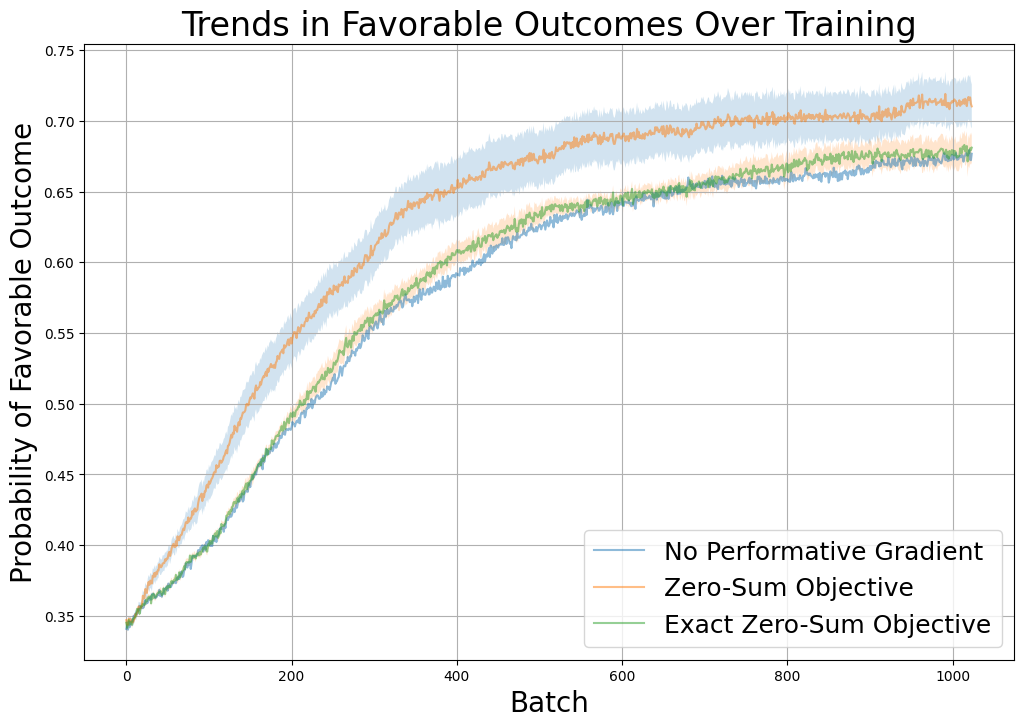

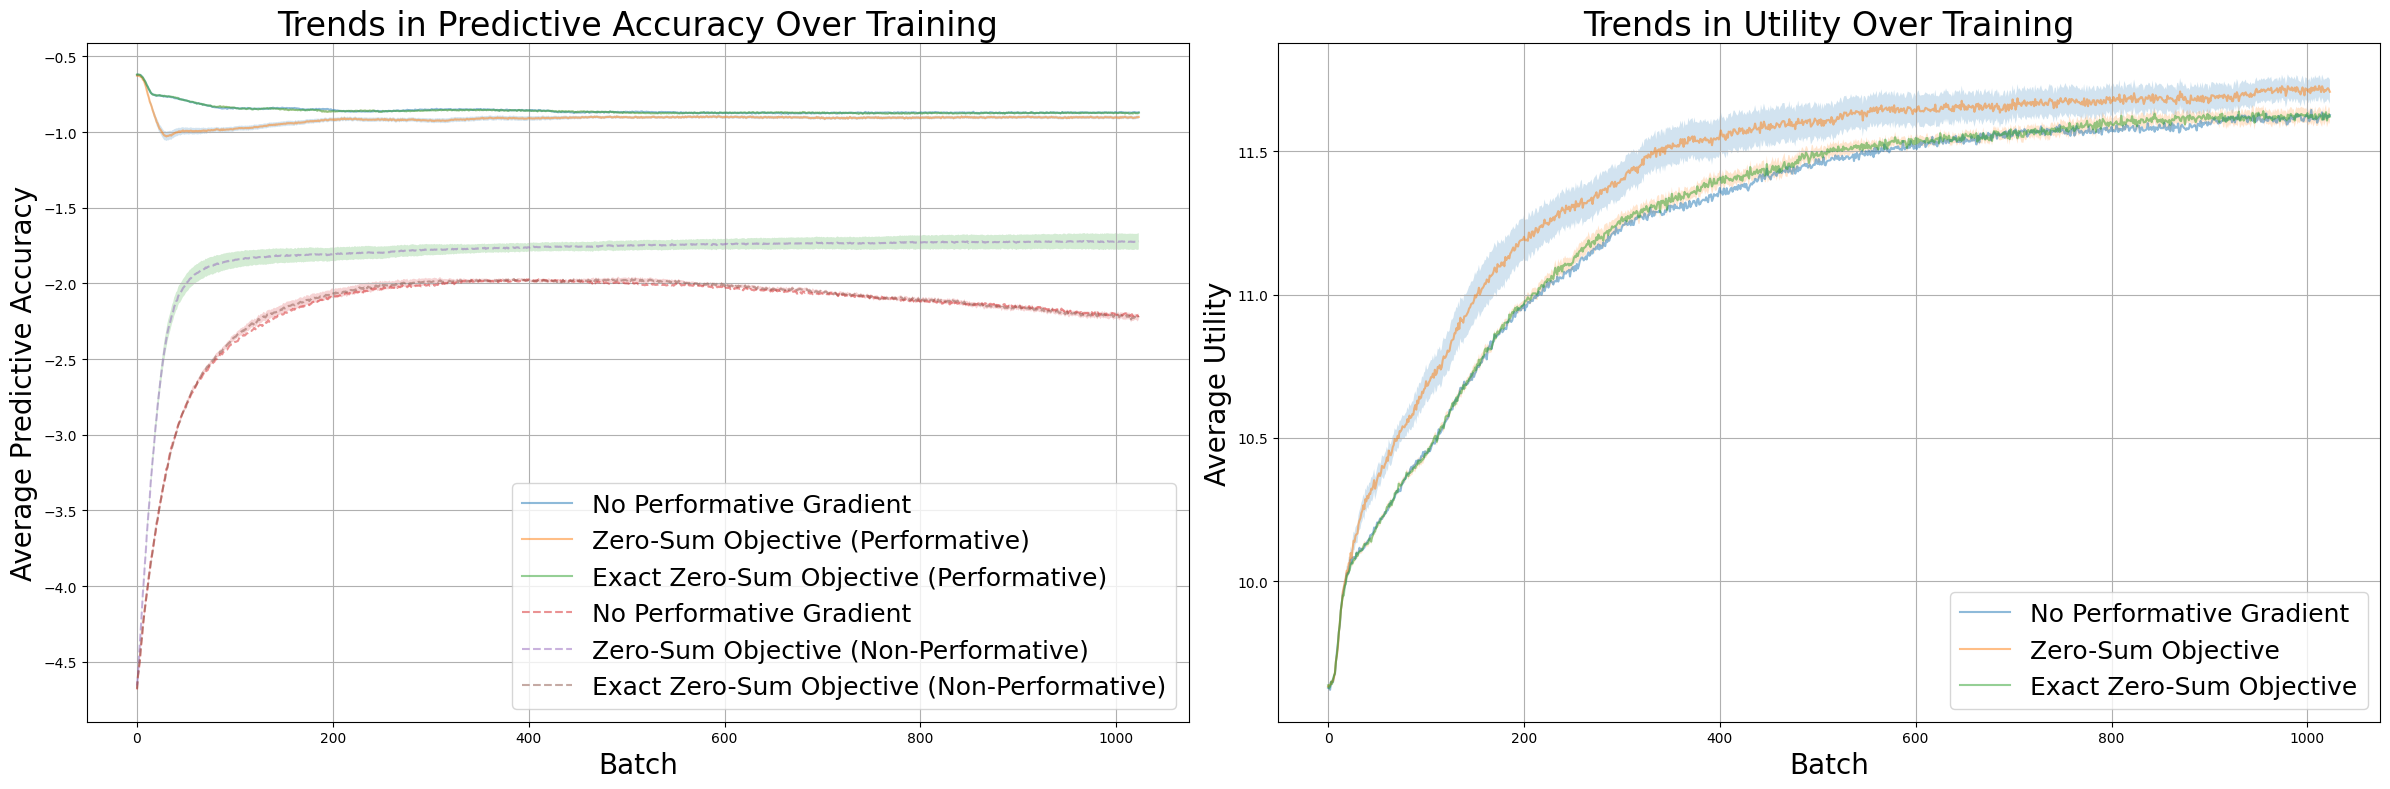

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create two separate figures
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
fig2, ax3 = plt.subplots(1, 1, figsize=(12, 8))

# Prepare data for plotting
performative_data = [
    (results['loss_record_stop'], 'No Performative Gradient'),
    (results['loss_record_zs'], 'Zero-Sum Objective'),
    (results['loss_record_zs_exact'], 'Exact Zero-Sum Objective')
]

non_performative_data = [
    (results['np_loss_record_stop'], 'No Performative Gradient'),
    (results['np_loss_record_zs'], 'Zero-Sum Objective'),
    (results['np_loss_record_zs_exact'], 'Exact Zero-Sum Objective')
]

utility_data = [
    (results['utility_record_stop'], 'No Performative Gradient'),
    (results['utility_record_zs'], 'Zero-Sum Objective'),
    (results['utility_record_zs_exact'], 'Exact Zero-Sum Objective')
]

prob_fav_data = [
    (results['prob_fav_record_stop'], 'No Performative Gradient'),
    (results['prob_fav_record_zs'], 'Zero-Sum Objective'),
    (results['prob_fav_record_zs_exact'], 'Exact Zero-Sum Objective')
]

batch_num = torch.arange(n_batches)

# Plot performative accuracy
perf_baseline = performative_data[0][0]  # No Performative Gradient as baseline
baseline_mean_p = -1 * torch.mean(perf_baseline, dim=(0,2,3))
ax1.plot(batch_num, baseline_mean_p, label=performative_data[0][1], alpha=0.5)

for data, label in performative_data[1:]:
    mean, stderr = get_relative_stats(-1 * data, -1 * perf_baseline)
    relative_mean = baseline_mean_p + mean
    ax1.plot(batch_num, relative_mean, label=label + ' (Performative)', alpha=0.5)
    ax1.fill_between(batch_num, relative_mean - stderr, relative_mean + stderr, alpha=0.2)

# Plot non-performative accuracy
np_baseline = non_performative_data[0][0]  # No Performative Gradient as baseline
baseline_mean_np = -1 * torch.mean(np_baseline, dim=(0,2,3))
ax1.plot(batch_num, baseline_mean_np, label=non_performative_data[0][1], linestyle='--', alpha=0.5)

for data, label in non_performative_data[1:]:
    mean, stderr = get_relative_stats(-1 * data, -1 * np_baseline)
    relative_mean = baseline_mean_np + mean
    ax1.plot(batch_num, relative_mean, label=label + ' (Non-Performative)', linestyle='--', alpha=0.5)
    ax1.fill_between(batch_num, relative_mean - stderr, relative_mean + stderr, alpha=0.2)

# Plot utilities with relative differences
baseline = utility_data[0][0]  # No Performative Gradient as baseline
baseline_mean = torch.mean(baseline, dim=(0,2,3))
ax2.plot(batch_num, baseline_mean, label=utility_data[0][1], alpha=0.5)

for data, label in utility_data[1:]:
    mean, stderr = get_relative_stats(data, baseline)
    relative_mean = baseline_mean + mean
    ax2.plot(batch_num, relative_mean, label=label, alpha=0.5)
    ax2.fill_between(batch_num, relative_mean - stderr, relative_mean + stderr, alpha=0.2)

# Plot probability of favorable outcomes
baseline = prob_fav_data[0][0]  # No Performative Gradient as baseline
baseline_mean = torch.mean(baseline, dim=(0,2,3))
ax3.plot(batch_num, baseline_mean, label=prob_fav_data[0][1], alpha=0.5)

for data, label in prob_fav_data[1:]:
    mean, stderr = get_relative_stats(data, baseline)
    relative_mean = baseline_mean + mean
    ax3.plot(batch_num, relative_mean, label=label, alpha=0.5)
    ax3.fill_between(batch_num, relative_mean - stderr, relative_mean + stderr, alpha=0.2)

ax1.set_xlabel('Batch', fontsize=20)
ax1.set_ylabel('Average Predictive Accuracy', fontsize=20)
ax1.set_title('Trends in Predictive Accuracy Over Training', fontsize=24)
ax1.legend(fontsize=18)
ax1.grid(True)

ax2.set_xlabel('Batch', fontsize=20)
ax2.set_ylabel('Average Utility', fontsize=20)
ax2.set_title('Trends in Utility Over Training', fontsize=24)
ax2.legend(fontsize=18)
ax2.grid(True)

ax3.set_xlabel('Batch', fontsize=20)
ax3.set_ylabel('Probability of Favorable Outcome', fontsize=20)
ax3.set_title('Trends in Favorable Outcomes Over Training', fontsize=24)
ax3.legend(fontsize=18)
ax3.grid(True)

plt.figure(1)
plt.tight_layout()
plt.show()

plt.figure(2)
plt.tight_layout()
plt.show()